<h2>Model Selection in ML</h2>

Model selection is the process of choosing the best learning algorithm and configuration for a given problem, not just based on training accuracy, but on how well it generalises to unseen data.

In this practice, we explore the essential tools for principled model selection:

    Train/test split to evaluate generalisation

    Cross-validation to reduce variance in estimates

    Hyperparameter tuning (GridSearchCV) to optimise model behaviour

    Validation curves to observe how performance changes with model complexity (e.g., regularization strength C)

    Learning curves to diagnose whether the model benefits from more data or is under-/over-fitting

    Metric selection (F1-score) to reflect the task’s priorities (especially in imbalanced classification)

    Model comparison to identify which algorithm (Logistic Regression, SVM, Random Forest) offers the best trade-off between accuracy, complexity, and interpretability

Together, these techniques ensure you don’t just train a model but that you choose the right one, for the right reasons, and backed by measurable evidence.

In [2]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve, learning_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import numpy as np

data = load_breast_cancer()
X, y = data.data, data.target

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=42)

In [3]:
# Cross validation
clf = LogisticRegression(max_iter=10000)
scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
print("Cross-val Accuracy (LogReg):", np.mean(scores))

Cross-val Accuracy (LogReg): 0.9623734177215189


This performs 5-fold cross-validation:

    It splits X_train into 5 parts (folds)

    Trains on 4, tests on 1 — repeats 5 times

    Returns 5 accuracy scores (one per fold)

np.mean(scores) gives the average CV accuracy, a better estimate of how the model performs on unseen data.

Interpretation of Cross-val Accuracy (LogReg): 0.9623 → On average, logistic regression got 96.2% accuracy on unseen data within training set folds. Therefore, we conclude it is a strong model.

In [5]:
# Hyperparameter tuning (grid search)
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

grid = GridSearchCV(LogisticRegression(max_iter=10000), param_grid, cv=5, scoring='f1')
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("F1 on test:", classification_report(y_test, grid.predict(X_test)))

Best Params: {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
F1 on test:               precision    recall  f1-score   support

           0       0.97      0.89      0.93        64
           1       0.94      0.98      0.96       107

    accuracy                           0.95       171
   macro avg       0.95      0.94      0.94       171
weighted avg       0.95      0.95      0.95       171



<b>GridSearchCV</b> tries every combination of hyperparameters you give, uses cross-validation on each, and tells which combination performed best. It’s like brute-force tuning with systematic testing.

<b>F1 scoring</b> = harmonic mean of precision and recall

<b>C:</b> Inverse of regularisation strength in LogisticRegression.

    Higher C → less regularisation

    Lower C → stronger penalty on coefficients

<b>solver:</b> Optimisation algorithm used internally.

    'lbfgs': fast and accurate for small/mid-sized datasets.

    Alternatives: 'liblinear', 'saga', 'newton-cg'

📋 Classification Report (Best Model) interpretation:

    Precision/recall for class 1 is very high

    Implies the model is very good at identifying positives (likely the minority class)

    Overall accuracy and F1 = 95% — strong generalisation

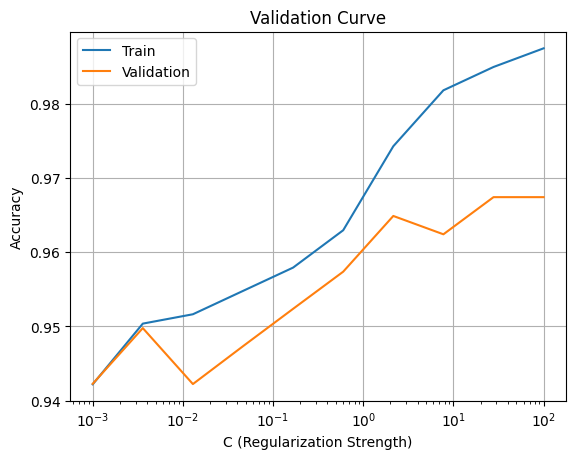

In [6]:
C_range = np.logspace(-3, 2, 10) # 10 values from 10 ** -3 to 10 ** 2, logarithmically spaced
train_scores, val_scores = validation_curve(
    LogisticRegression(max_iter=10000),
    X_train, y_train,
    param_name='C',
    param_range=C_range,
    cv=5, scoring='accuracy'
)

plt.plot(C_range, np.mean(train_scores, axis=1), label='Train')
plt.plot(C_range, np.mean(val_scores, axis=1), label='Validation')
plt.xscale('log')
plt.xlabel('C (Regularization Strength)')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Validation Curve')
plt.grid()
plt.show()

<b>Validation curve shows how model responds to tuning. It varies one hyperparameter (e.g. C)</b>

📈 Interpretation of the graph

    Validation score peaks around C ≈ 1–10

    Higher C improves train accuracy, but may slightly hurt validation

    Ideal C balances both

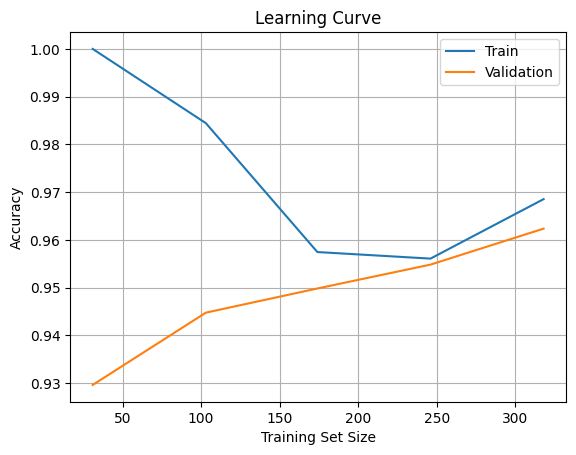

In [7]:
train_sizes, train_scores, val_scores = learning_curve(
    LogisticRegression(max_iter=10000),
    X_train, y_train,
    cv=5, scoring='accuracy',
    train_sizes=np.linspace(0.1, 1.0, 5)
)

plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Train')
plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve')
plt.legend()
plt.grid()
plt.show()

<b>Learning curve shows if model improves with more data by varying the training set size</b>

📈 Interpretation of the graph

    Train accuracy drops, validation accuracy rises

    → Classic sign of a well-generalizing model

    The model starts overfitting (high train acc), then generalizes better as it sees more data

In [8]:
models = {
    "Logistic": LogisticRegression(max_iter=10000),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier()
}

for name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')
    print(f"{name}: mean F1 = {np.mean(scores):.4f}")

Logistic: mean F1 = 0.9702
SVM: mean F1 = 0.9338
Random Forest: mean F1 = 0.9740


<b>Interpretation:</b>

    All models do well, but Random Forest slightly outperforms others

    Logistic Regression is almost equal, and simpler

    SVM is still decent but slightly behind

<b>Conclusion:</b>

    → Use Random Forest if you want highest raw F1
    → Use Logistic Regression if you want explainability + performance